In [222]:
import dataimport 
import pca_decomp as pca
import pandas as pd
import matplotlib.pyplot as plt

#For regression
import pandas as pd
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np



In [223]:

#Importing the datacode 
data_code = pd.read_excel("C:/Users/tchozin/Desktop/Python projects/Dual Mandate Forecast/data_pce_lead.xlsx")
df_main_pca, df_main_reg, df_raw = dataimport.data_main(data_code ,1990)

#Making sure both input and output series are same length
df_clean_pca =  df_main_pca[12:len(df_main_pca)-1].fillna(method='bfill').fillna(method='ffill')
df_clean_reg =  df_main_reg[12:len(df_main_reg)-1].fillna(method='bfill').fillna(method='ffill')


C:\Users\tchozin\AppData\Local\Temp\ipykernel_24392\3424936721.py:6: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_clean_pca =  df_main_pca[12:len(df_main_pca)-1].fillna(method='bfill').fillna(method='ffill')
C:\Users\tchozin\AppData\Local\Temp\ipykernel_24392\3424936721.py:7: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_clean_reg =  df_main_reg[12:len(df_main_reg)-1].fillna(method='bfill').fillna(method='ffill')


In [224]:
principal_comp, eigenvalues = pca.pca_model(df_clean_pca)
principal_comp_firstfour = principal_comp.iloc[:, :4] 


ValueError: Length mismatch: Expected axis has 25 elements, new values have 42 elements

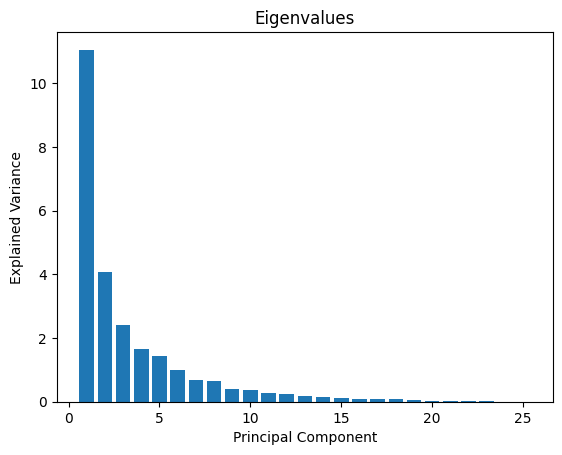

In [ ]:

#Plotting the eigen values
plt.bar(range(1, len(eigenvalues) + 1), eigenvalues)
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance')
plt.title('Eigenvalues')
plt.show()


In [ ]:

#combining the data frame for input variables and greating lagged value
lagg_for_depend = 3
lagg_for_pca = 3

#This is to add new rows when shifting the data up ward
new_date_index = pd.date_range(start=principal_comp_firstfour.index[-1] + pd.Timedelta(days=1), periods=lagg_for_pca, freq='MS')
new_rows = pd.DataFrame(np.nan, index=new_date_index, columns=["extrarow"])

#the X values just eh PCA
#pcshifted = pd.concat([principal_comp_firstfour, new_rows], axis=1).resample('MS').first()

#This is with a lag of the output variable
pcshifted = pd.concat([df_clean_reg, principal_comp_firstfour, new_rows], axis=1).resample('MS').first()

del pcshifted['extrarow'] 

df_combined_lagged = pd.concat([pcshifted.shift(lagg_for_pca)], axis=1)
#main data resizing to compensate for the na values

df_clean_reg_resize = df_clean_reg[lagg_for_depend:] #.dropna()
df_combined_lagged_main = df_combined_lagged[lagg_for_depend:] #.dropna()



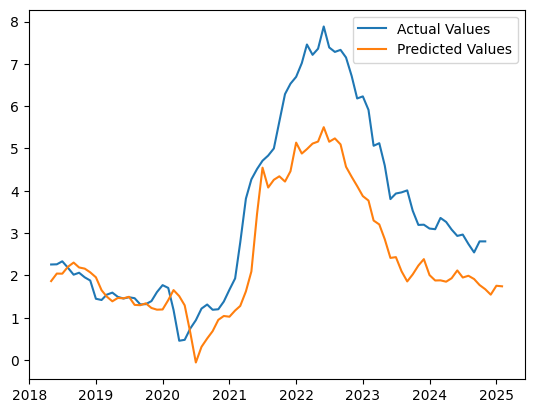

In [ ]:
# Split data into training and testing sets (80% training, 20% testing)
train_size = int(len(df_combined_lagged_main) * 0.8)
X_train, X_test = df_combined_lagged_main[:train_size], df_combined_lagged_main[train_size:]
Y_train, Y_test = df_clean_reg_resize[:train_size], df_clean_reg_resize[train_size:]


lr = LinearRegression()
lr.fit(X_train, Y_train)
y_pred = lr.predict(X_test)

y_pred = pd.DataFrame(y_pred, index=X_test.index.values, columns=["Predicted"])

plt.plot(Y_test, label="Actual Values")
plt.plot(y_pred, label="Predicted Values")
plt.legend()
plt.show()



In [ ]:

#summary statistics
import statsmodels.api as sm
log_clf =sm.OLS(df_clean_reg_resize ,df_combined_lagged_main.iloc[:, 1:5][:len(df_clean_reg_resize)])
classifier = log_clf.fit()
print(classifier.summary2())


                             Results: Ordinary least squares
Model:                  OLS                        Adj. R-squared (uncentered): 0.269    
Dependent Variable:     _OUTPUT_12MCHNG_USPRIC0001 AIC:                         1704.1049
Date:                   2024-12-02 13:26           BIC:                         1720.1105
No. Observations:       404                        Log-Likelihood:              -848.05  
Df Model:               4                          F-statistic:                 38.14    
Df Residuals:           400                        Prob (F-statistic):          4.83e-27 
R-squared (uncentered): 0.276                      Scale:                       3.9367   
------------------------------------------------------------------------------------------------
               Coef.         Std.Err.           t           P>|t|          [0.025         0.975]
------------------------------------------------------------------------------------------------
PC1            0.3

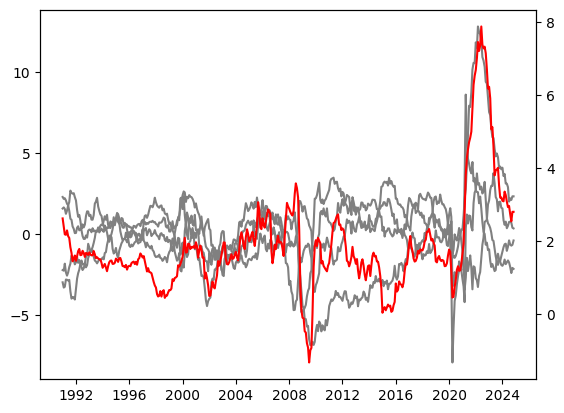

In [ ]:

fig, ax1 = plt.subplots()
ax1.plot(principal_comp.iloc[:, :4], color='gray')
ax2 = ax1.twinx()
ax2.plot(df_clean_reg , color='red')
plt.show()

C:\Users\tchozin\AppData\Local\Temp\ipykernel_24392\526297239.py:37: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  ax2.plot(df_clean_reg.shift(0), 'b', label='PCE (rs)', linestyle='--', color='black')  # Plot on the secondary axis


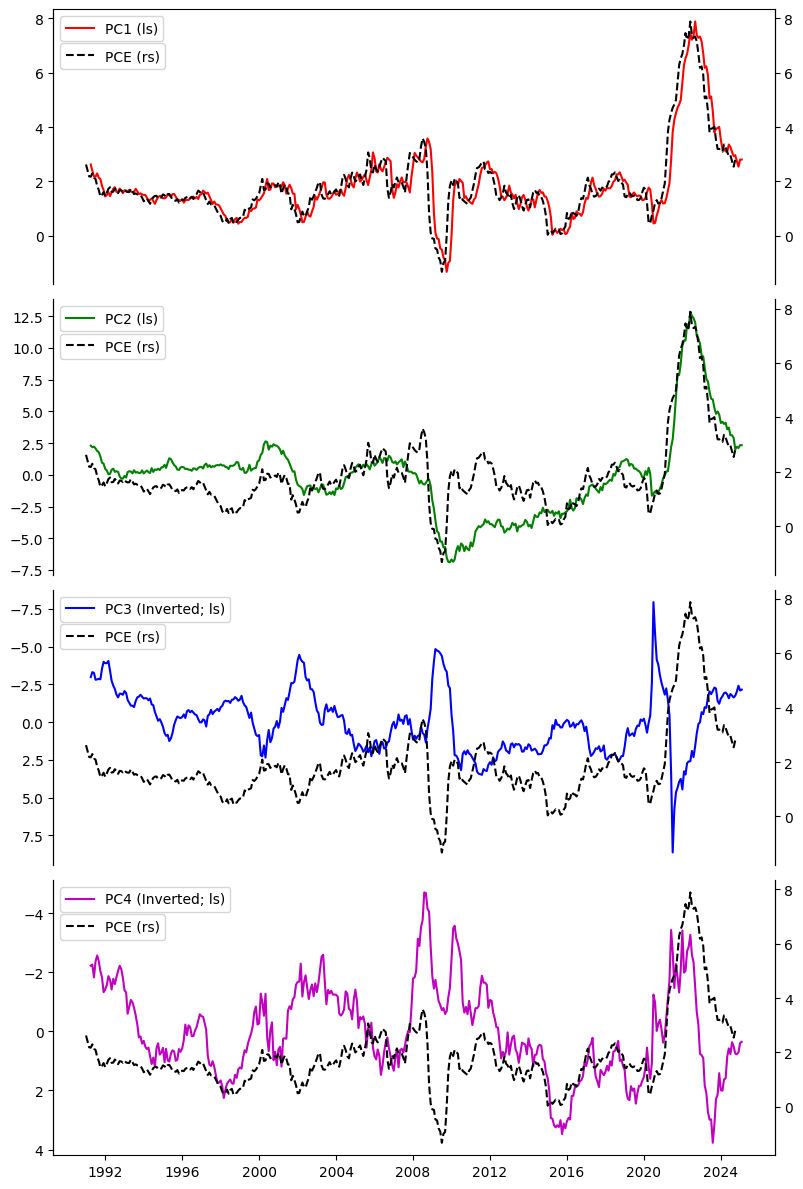

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Create a 4x1 grid of subplots (all aligned vertically)
fig, axs = plt.subplots(4, 1, figsize=(8, 12))

# Plot in the first panel (top)
axs[0].plot(df_combined_lagged_main.iloc[:, :1], 'r', label='PC1 (ls)')
axs[0].spines['bottom'].set_visible(False)
axs[0].set_xticks([])  # Remove x-axis labels for the fourth plot
axs[0].legend(loc='upper left')

# Plot in the second panel
axs[1].plot(df_combined_lagged_main.iloc[:, 1:2], 'g', label='PC2 (ls)')
axs[1].spines['top'].set_visible(False)
axs[1].spines['bottom'].set_visible(False)
axs[1].set_xticks([])  # Remove x-axis labels for the fourth plot
axs[1].legend(loc='upper left')

# Plot in the third panel
axs[2].plot(df_combined_lagged_main.iloc[:, 2:3], 'b', label='PC3 (Inverted; ls)')
#axs[2].set_ylim(-10, 10)  # Limit y-axis for tan(x) to avoid extreme values
axs[2].spines['top'].set_visible(False)
axs[2].spines['bottom'].set_visible(False)
axs[2].set_xticks([])  # Remove x-axis labels for the fourth plot
axs[2].legend(loc='upper left')
axs[2].invert_yaxis()
# Plot in the fourth panel (bottom)
axs[3].plot(df_combined_lagged_main.iloc[:, 3:4], 'm', label='PC4 (Inverted; ls)')
axs[3].spines['top'].set_visible(False)
axs[3].legend(loc='upper left')
axs[3].invert_yaxis()


for i in range(4):
    ax2 = axs[i].twinx()  # Get the secondary axis for each subplot
    ax2.plot(df_clean_reg.shift(0), 'b', label='PCE (rs)', linestyle='--', color='black')  # Plot on the secondary axis
    ax2.spines['top'].set_visible(False)
    ax2.spines['bottom'].set_visible(False)
    ax2.legend(loc='upper left',bbox_to_anchor=(0, 0.9))  # Optional: Add a legend for the second series
# Adjust the layout to prevent overlap
plt.tight_layout()

# Show the figure with the four vertically aligned panels
plt.show()